![](./mitiq-logo.png)

[Mitiq](https://quantum-journal.org/papers/q-2022-08-11-774/) is a Python toolkit for implementing error mitigation techniques on quantum computers.

Current quantum computers are noisy due to interactions with the environment, imperfect gate applications, state preparation and measurement errors, etc. Error mitigation seeks to reduce these effects at the software level by compiling quantum programs in clever ways.

# Clifford Data Regression

Clifford data regression (CDR) is a learning-based quantum error mitigation technique in which an error mitigation model is trained with quantum circuits that _resemble_ the circuit of interest, but which are easier to classically simulate [1](https://link.aps.org/doi/10.1103/PhysRevResearch.3.033098), [2](http://dx.doi.org/10.22331/q-2021-11-26-592).

![](./cdr_workflow2_steps.png)

The CDR workflow Figure above shows a schema of the implementation of CDR in Mitiq. Similarly to ZNE and PEC, also CDR in Mitiq is divided in two main stages: The first one of circuit generation and the second for inference of the mitigated value. However, in CDR, the generation of quantum circuits is different, as it involves the generation of training circuits. The division of CDR into training, learning and prediction stages is shown in the figure below.


![](./cdr_diagram2.png)

Near-Clifford approximations of the actual circuit are simulated, without noise, on a classical simulator (circuits can be efficiently simulated classically) and executed on the noisy quantum computer (or a noisy simulator). These results are used as training data to infer the zero-noise expectation value of the error miitigated original circuit, that is finally run on the quantum computer (or noisy simulator)

# When should I use CDR?

## Advantages

The main advantage of CDR is that it can be applied without knowing the specific details of the noise
model. Indeed, in CDR, the effects of noise are indirectly _learned_ through the execution of an appropriate
set of test circuits. In this way, the final error mitigation inference tends to self-tune with respect
to the used backend.

This self-tuning property is even stronger in the case of _variable-noise-CDR_, i.e., when using the _scale_factors_ option
in {func}`.execute_with_cdr`. In this case, the final error mitigated expectation value is obtained
as a linear combination of noise-scaled expectation values. This is similar to the [ZNE approach](zne-5-theory.md) but, in CDR, 
the coefficients of the linear combination are learned instead of being fixed by the extrapolation model.


## Disadvantages

The main disadvantage of CDR is that the learning process is performed on a suite of test circuits which
only _resemble_ the original circuit of interest. Indeed, test circuits are _near-Clifford approximations_
of the original one. Only when the approximation is justified, the application of CDR can produce meaningful
results.
Increasing the `fraction_non_clifford` option in {func}`.execute_with_cdr` can alleviate this problem
to some extent. Note that, the larger `fraction_non_clifford` is, the larger the classical computation overhead is.

Another relevant aspect to consider is that, to apply CDR in a scalable way, a valid near-Clifford simulator
is necessary. Note that the computation cost of a valid near-Clifford simulator should scale with the number of non-Clifford
gates, independently from the circuit depth. Only in this case, the learning phase of CDR can be applied efficiently.


# What is the theory behind CDR?

Clifford data regression (CDR) is a quantum error mitigation technique that has been introduced in Ref. {cite}`Czarnik_2021_Quantum` and extended to variable-noise CDR in Ref. {cite}`Lowe_2021_PRR`.
. The presented error mitigation (EM) strategy is designed for gate-based quantum computers. This method primarily consists of creating a training data set $\{(X_{\phi_i}^{\text{error}}, X_{\phi_i}^{\text{exact}})\}$, where $X_{\phi_i}^{\text{error}}$ and $X_{\phi_i}^{\text{exact}}$ are the expectation values of an observable $X$ for a state $|\phi_i\rangle$ under error and error-free conditions, respectively. 

This method includes the following steps:

## Step 1: Choose Near-Clifford Circuits for Training

Near-Clifford circuits are selected due to their capability to be efficiently simulated classically, and are denoted by $S_\psi=\{|\phi_i\rangle\}_i$.

## Step 2: Construct the Training Set 

The training set $\{(X_{\phi_i}^{\text{error}}, X_{\phi_i}^{\text{exact}})\}_i$ is constructed by calculating the expectation values of $X$ for each state $|\phi_i\rangle$ in $S_\psi$, on both a quantum computer (to obtain $X_{\phi_i}^{\text{error}}$) and a classical computer (to obtain $X_{\phi_i}^{\text{exact}}$).

## Step 3: Learn the Error Mitigation Model

A model $f(X^{\text{error}}, a)$ for $X^{exact}$ is defined and learned. Here, $a$ is the set of parameters to be determined. This is achieved by minimizing the distance between the training set, as expressed by the following optimization problem:

$$a_{opt} = \underset{a}{\text{argmin}} \sum_i \left| X_{\phi_i}^{\text{exact}} - f(X_{\phi_i}^{\text{error}},a) \right|^2.$$

In this expression, $a_{opt}$ are the parameters that minimize the cost function.

## Step 4: Apply the Error Mitigation Model

Finally, the learned model $f(X^{\text{error}}, a_{opt})$ is used to correct the expectation values of $X$ for new quantum states, expressed as $X_\psi^{\text{exact}} = f(X_\psi^{\text{error}}, a_{opt})$.

The effectiveness of this method has been proven on circuits with up to 64 qubits and for tasks such as estimating ground-state energies. However, its performance is dependent on the task, the system, the quality of the training data, and the choice of model.



# How do I use CDR?

Here we show how to use CDR by means of a simple example.

In [1]:
import numpy as np
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)

import cirq
from mitiq import cdr, Observable, PauliString


## Problem setup

To use CDR, we call {func}`.cdr.execute_with_cdr` with four "ingredients":

1. A quantum circuit to prepare a state $\rho$.
1. A quantum computer or noisy simulator to return a {class}`.QuantumResult` from $\rho$.
1. An observable $O$ which specifies what we wish to compute via $\text{Tr} [ \rho O ]$.
1. A near-Clifford (classical) circuit simulator.


### 1. Define a quantum circuit

The quantum circuit can be specified as any quantum circuit supported by Mitiq but
**must be compiled into a gateset in which the only non-Clifford gates are
single-qubit rotations around the $Z$ axis: $R_Z(\theta)$**.  For example:

$$\{ \sqrt{X}, R_Z(\theta), \text{CNOT}\},$$
$$\{{R_X(\pi/2)}, R_Z(\theta), \text{CZ}\},$$
$$\{H, S, R_Z(\theta), \text{CNOT}\},$$
$$ \dots$$

In the next cell we define (as an example) a quantum circuit which contains some
Clifford gates and some non-Clifford $R_Z(\theta)$ rotations.


In [2]:
a, b = cirq.LineQubit.range(2)
circuit = cirq.Circuit(
    cirq.H.on(a), # Clifford
    cirq.H.on(b), # Clifford
    cirq.rz(1.75).on(a),
    cirq.rz(2.31).on(b),
    cirq.CNOT.on(a, b),  # Clifford
    cirq.rz(-1.17).on(b),
    cirq.rz(3.23).on(a),
    cirq.rx(np.pi / 2).on(a),  # Clifford
    cirq.rx(np.pi / 2).on(b),  # Clifford
)

# CDR works better if the circuit is not too short. So we increase its depth.
circuit = 5 * circuit

### Define an executor


In [3]:
from mitiq.interface.mitiq_cirq import compute_density_matrix

compute_density_matrix(circuit).round(3)


array([[ 0.834+0.j   , -0.027+0.075j, -0.004+0.061j, -0.022-0.052j],
       [-0.027-0.075j,  0.057-0.j   ,  0.007-0.006j, -0.003+0.002j],
       [-0.004-0.061j,  0.007+0.006j,  0.053+0.j   , -0.005+0.004j],
       [-0.022+0.052j, -0.003-0.002j, -0.005-0.004j,  0.056+0.j   ]],
      dtype=complex64)

### Observable
As an example, assume that we wish to compute the expectation value $\text{Tr} [ \rho O ]$ of the following observable $O$:

In [4]:
# Observable to measure.
obs = Observable(PauliString("ZZ"), PauliString("X", coeff=-1.75))
print(obs)

Z(q(0))*Z(q(1)) + (-1.75+0j)*X(q(0))


### (Near-Clifford) Simulator
The CDR method creates a set of "training circuits" which are related to the input circuit and are efficiently simulable. These circuits are simulated on a classical (noiseless) simulator to collect data for regression. The simulator should also return a `QuantumResult`.

In [5]:
def simulate(circuit: cirq.Circuit) -> np.ndarray:
    return compute_density_matrix(circuit, noise_level=(0.0,))

simulate(circuit).round(3)

array([[ 0.982-0.j   , -0.016+0.081j, -0.004+0.049j, -0.049-0.075j],
       [-0.016-0.081j,  0.007-0.j   ,  0.004-0.j   , -0.005+0.005j],
       [-0.004-0.049j,  0.004+0.j   ,  0.002+0.j   , -0.004+0.003j],
       [-0.049+0.075j, -0.005-0.005j, -0.004-0.003j,  0.008+0.j   ]],
      dtype=complex64)

# Run CDR
We first compute the noiseless result then the noisy result to compare to the mitigated result from CDR.

In [6]:
ideal_measurement = obs.expectation(circuit, simulate).real
print("ideal_measurement = ",ideal_measurement)

unmitigated_measurement = obs.expectation(circuit, compute_density_matrix).real
print("unmitigated_measurement = ", unmitigated_measurement)

mitigated_measurement = cdr.execute_with_cdr(
    circuit,
    compute_density_matrix,
    observable=obs,
    simulator=simulate,
    seed=0,
).real
print("mitigated_measurement = ", mitigated_measurement)

error_unmitigated = abs(unmitigated_measurement-ideal_measurement)
error_mitigated = abs(mitigated_measurement-ideal_measurement)

print("Error (unmitigated):", error_unmitigated)
print("Error (mitigated with CDR):", error_mitigated)

print("Relative error (unmitigated):", (error_unmitigated/ideal_measurement))
print("Relative error (mitigated with CDR):", error_mitigated/ideal_measurement)

print(f"Error reduction with CDR: {(error_unmitigated-error_mitigated)/error_unmitigated :.1%}.")


ideal_measurement =  1.0153722763061523
unmitigated_measurement =  0.8030939102172852
mitigated_measurement =  1.0307368605094165
Error (unmitigated): 0.2122783660888672
Error (mitigated with CDR): 0.015364584203264142
Relative error (unmitigated): 0.20906456778701882
Relative error (mitigated with CDR): 0.01513197135848473
Error reduction with CDR: 92.8%.


# Qiskit Native
See [here](https://github.com/renatawong/clifford-data-regression-qiskit/blob/main/Clifford_data_regression_Qiskit.ipynb)

In [1]:
'''
(C) Copyright Renata Wong 2023.

This code is licensed under the Apache License, Version 2.0. You may obtain a copy of this license 
at http://www.apache.org/licenses/LICENSE-2.0.

Any modifications or derivative works of this code must retain this copyright notice, and modified files 
need to carry a notice indicating that they have been altered from the originals.

For details see 
Piotr Czarnik, Andrew Arrasmith, Patrick J. Coles, and Lukasz Cincio. 
"Error mitigation with Clifford quantum-circuit data". Quantum 5, 592 (2021).
'''

from qiskit import QuantumCircuit, QuantumRegister
import numpy as np

# imports for generating training circuits
from qiskit.circuit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import TransformationPass
import numpy as np
import random
from random import choices


nqubits = 2
nshots = 20000

def getParity(n):
    parity = 0
    while n:
        parity = ~parity
        n = n & (n - 1)
    return parity

import itertools
def expectation_value_from_counts(counts):
    exp_val = 0
    for x in map(''.join, itertools.product('01', repeat=nqubits)):
        if x in counts:   # making sure that x is in the output as the counts dictionary contains no values with 0 occurrence
            if getParity(int(x,2)) == -1:
                exp_val = exp_val - counts[x]
            if getParity(int(x,2)) == 0:
                exp_val = exp_val + counts[x]
    return exp_val/nshots

# mapping circuit to near Clifford circuits with N = number of non-Clifford gates
# Z gates with these angles/exponents are Clifford gates.
clifford_exponents = np.array([0.0, 0.5, 1.0, 1.5])
clifford_angles = [exponent * np.pi for exponent in clifford_exponents]


# replacing some non-Clifford gates with Clifford gates in the input circuit

class RZTranslator(TransformationPass):
    """A transpiler pass to replace RZ(a) gates with RZ(pi/2)^n gates, for n = 0, 1, 2, 3 at random."""

    def run(self, dag):
        N = 0.3                                   # TUNABLE: here, replace 30% of the non-Clifford gates
        # iterate over all operations
        for node in dag.op_nodes():

            # if we hit a RZ gate replace it by RZ(pi/2)^n at random
            if node.op.name in ["rz"]:
                # get the rotation angle
                angle = node.op.params[0]

                # calculate the replacement
                replacement = QuantumCircuit(1)
                if node.op.name == "rz":
                    if angle not in clifford_angles:
                        if choices([0,1], [N, 1-N])[0] == 0:
                            replacement.rz(random.choice(clifford_angles),0)
                        else:
                            replacement.rz(angle,0)

                # replace the node with our new decomposition
                dag.substitute_node_with_dag(node, circuit_to_dag(replacement))
        
        return dag
   
    
# Least-squares regression from scipy
#from scipy.stats import linregress
def least_squares_regression(noiseless_exp_vals, noisy_exp_vals):
    result = scipy.stats.linregress(noisy_exp_vals, noiseless_exp_vals)
    return (result.slope, result.intercept)




'''
EXAMPLE CIRCUIT. ADJUSTABLE. 
'''
def append_gates(qc):
    for rep in range(5):
        for qubit in range(nqubits):
            qc.h(qubit)  
        for qubit in range(nqubits)[::2]:
            qc.rz(1.75, qubit)
        for qubit in range(nqubits)[1::2]:
            qc.rz(2.31, qubit)
        for qubit in range(nqubits)[::2]:
            qc.cx(qubit, qubit+1)     
        for qubit in range(nqubits)[::2]:
            qc.rz(-1.17, qubit)
        for qubit in range(nqubits)[1::2]:
            qc.rz(3.23, qubit)
        for qubit in range(nqubits):
            qc.rx(np.pi/2, qubit)    
    return qc

# The original vcircuit
qc = QuantumCircuit(nqubits)
append_gates(qc)

training_circuits_no_measurement_all = []  
for _ in range(500):
    training_circuits_no_measurement_all.append(RZTranslator()(qc))

print(*training_circuits_no_measurement_all)

     ┌───┐┌──────────┐     ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
q_0: ┤ H ├┤ Rz(1.75) ├──■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(3π/2) ├──■──»
     ├───┤└┬───────┬─┘┌─┴─┐└┬──────────┤├─────────┤├───┤├──────────┤┌─┴─┐»
q_1: ┤ H ├─┤ Rz(0) ├──┤ X ├─┤ Rz(3π/2) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├»
     └───┘ └───────┘  └───┘ └──────────┘└─────────┘└───┘└──────────┘└───┘»
«     ┌─────────┐ ┌─────────┐┌───┐┌──────────┐     ┌───────┐┌─────────┐┌───┐»
«q_0: ┤ Rz(π/2) ├─┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──┤ Rz(0) ├┤ Rx(π/2) ├┤ H ├»
«     ├─────────┴┐├─────────┤├───┤├──────────┤┌─┴─┐├───────┤├─────────┤├───┤»
«q_1: ┤ Rz(3.23) ├┤ Rx(π/2) ├┤ H ├┤ Rz(2.31) ├┤ X ├┤ Rz(0) ├┤ Rx(π/2) ├┤ H ├»
«     └──────────┘└─────────┘└───┘└──────────┘└───┘└───────┘└─────────┘└───┘»
«      ┌───────┐       ┌───────────┐┌─────────┐┌───┐┌──────────┐     »
«q_0: ─┤ Rz(π) ├────■──┤ Rz(-1.17) ├┤ Rx(π/2) ├┤ H ├┤ Rz(1.75) ├──■──»
«     ┌┴───────┴─┐┌─┴─┐└┬──────────┤├─────────┤├───┤├──────────┤┌─┴─┐»
«q_1: ┤ Rz(3π/2) ├┤ X 

In [2]:
# wrapping the circuit into a statefunction
# This does not take simulation output into account, hence is always the same, while simulation with measurement varies.
from qiskit.opflow import Z, StateFn, CircuitStateFn

observable = Z ^ 2

# expectation value of the original circuit
psi_qc = CircuitStateFn(qc)
exp_val_qc = (~psi_qc @ observable @ psi_qc).eval()
print('Exact expectation value of circuit of interest:', exp_val_qc.real)

noiseless_exp_vals = []   
training_circuits_no_measurement = []
for circuit in training_circuits_no_measurement_all: 
    psi = CircuitStateFn(circuit)
    expectation_value = (~psi @ observable @ psi).eval()
    if expectation_value >= exp_val_qc.real-0.05 and expectation_value <= exp_val_qc.real+0.05:
        noiseless_exp_vals.append(expectation_value.real)
        training_circuits_no_measurement.append(circuit)


for exp_val in noiseless_exp_vals:
    print('Exact expectation value:', exp_val)


/tmp/ipykernel_41702/563692001.py:3: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import Z, StateFn, CircuitStateFn
/tmp/ipykernel_41702/563692001.py:8: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  psi_qc = CircuitStateFn(qc)
/tmp/ipykernel_41702/563692001.py:15: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  psi = CircuitStateFn(circuit)


Exact expectation value of circuit of interest: 0.20422260124463615
Exact expectation value: 0.16958372411652695
Exact expectation value: 0.23622858926421905
Exact expectation value: 0.19127217219240783
Exact expectation value: 0.16037208196590028
Exact expectation value: 0.18045828990365353
Exact expectation value: 0.23798999571136692
Exact expectation value: 0.17847028870529946
Exact expectation value: 0.19688720436416984
Exact expectation value: 0.20422260124463615
Exact expectation value: 0.1749208085594161
Exact expectation value: 0.21042698744941885
Exact expectation value: 0.1584815914696728
Exact expectation value: 0.2281715707414368
Exact expectation value: 0.18226071361598256
Exact expectation value: 0.19186945492973054
Exact expectation value: 0.1584248477440083
Exact expectation value: 0.18362457315998393
Exact expectation value: 0.18425592649774195
Exact expectation value: 0.2453418788398238
Exact expectation value: 0.22860428046740033
Exact expectation value: 0.1928859428

In [3]:
'''
Generate training circuits with measurement for noisy simulation on quantum devices
'''


from qiskit import ClassicalRegister

# original circuit with measurement
qr_qc = QuantumRegister(nqubits)
cr_qc = ClassicalRegister(nqubits)
circ_qc = QuantumCircuit(qr_qc, cr_qc)
circ_qc.append(qc.to_instruction(), [qubit for qubit in range(nqubits)])
circ_qc.measure(qr_qc, cr_qc)

training_circuits_with_measurement = []
for circuit in training_circuits_no_measurement:
    qr = QuantumRegister(nqubits)
    cr = ClassicalRegister(nqubits)
    circ = QuantumCircuit(qr, cr)
    circ.append(circuit.to_instruction(), [qubit for qubit in range(nqubits)])
    circ.measure(qr, cr) 
    training_circuits_with_measurement.append(circ)
    
print(*training_circuits_with_measurement)


         ┌──────────────┐┌─┐   
q2506_0: ┤0             ├┤M├───
         │  circuit-120 │└╥┘┌─┐
q2506_1: ┤1             ├─╫─┤M├
         └──────────────┘ ║ └╥┘
   c1: 2/═════════════════╩══╩═
                          0  1           ┌──────────────┐┌─┐   
q2507_0: ┤0             ├┤M├───
         │  circuit-120 │└╥┘┌─┐
q2507_1: ┤1             ├─╫─┤M├
         └──────────────┘ ║ └╥┘
   c2: 2/═════════════════╩══╩═
                          0  1           ┌──────────────┐┌─┐   
q2508_0: ┤0             ├┤M├───
         │  circuit-120 │└╥┘┌─┐
q2508_1: ┤1             ├─╫─┤M├
         └──────────────┘ ║ └╥┘
   c3: 2/═════════════════╩══╩═
                          0  1           ┌──────────────┐┌─┐   
q2509_0: ┤0             ├┤M├───
         │  circuit-120 │└╥┘┌─┐
q2509_1: ┤1             ├─╫─┤M├
         └──────────────┘ ║ └╥┘
   c4: 2/═════════════════╩══╩═
                          0  1           ┌──────────────┐┌─┐   
q2510_0: ┤0             ├┤M├───
         │  circuit-120 │└╥┘┌─┐
q2510_1:

In [4]:
'''
Adding a noise model to our simulation
'''

from qiskit import transpile

from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo

from qiskit.providers.aer import AerSimulator

device_backend = FakeVigo()
coupling_map = device_backend.configuration().coupling_map
sim_vigo = AerSimulator.from_backend(device_backend)

noisy_exp_vals = []   
for circuit in training_circuits_with_measurement: 
    tqc = transpile(circuit, sim_vigo) 
    result_noise = sim_vigo.run(tqc, shots=nshots).result() 
    counts_noise = result_noise.get_counts(0) 
    noisy_exp_val = expectation_value_from_counts(counts_noise) 
    print('Noisy expectation value from counts: ', noisy_exp_val)
    noisy_exp_vals.append(noisy_exp_val)


/tmp/ipykernel_41702/4230046459.py:8: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo


Noisy expectation value from counts:  0.1355
Noisy expectation value from counts:  0.165
Noisy expectation value from counts:  0.1142
Noisy expectation value from counts:  0.1227
Noisy expectation value from counts:  0.1437
Noisy expectation value from counts:  0.1553
Noisy expectation value from counts:  0.1212
Noisy expectation value from counts:  0.1471
Noisy expectation value from counts:  0.1441
Noisy expectation value from counts:  0.1316
Noisy expectation value from counts:  0.1349
Noisy expectation value from counts:  0.1228
Noisy expectation value from counts:  0.1732
Noisy expectation value from counts:  0.1404
Noisy expectation value from counts:  0.1303
Noisy expectation value from counts:  0.1159
Noisy expectation value from counts:  0.1292
Noisy expectation value from counts:  0.1357
Noisy expectation value from counts:  0.1664
Noisy expectation value from counts:  0.1463
Noisy expectation value from counts:  0.1303
Noisy expectation value from counts:  0.1619
Noisy expec

In [5]:
import scipy

result = least_squares_regression(noiseless_exp_vals, noisy_exp_vals)

slope = result[0]
intercept = result[1]
print('Slope: ', slope, ' Intercept: ', intercept)


Slope:  1.251231882068707  Intercept:  0.02582839619225616


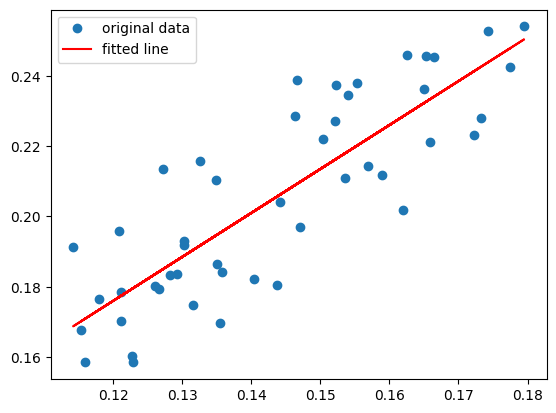

In [6]:
import matplotlib.pyplot as plt
plt.plot(noisy_exp_vals, noiseless_exp_vals, 'o', label='original data')
noisy_exp_vals = np.array(noisy_exp_vals)
plt.plot(noisy_exp_vals, slope*noisy_exp_vals + intercept, 'r', label='fitted line')

plt.legend()
plt.show()

In [7]:
'''
Prediction: run the original circuit and measure (= X_exact). 
Then, apply the function X_exact = slope*X_noisy + intercept to obtain the mitigated value. 
'''


# Running classical simulation
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram


# Testing: classical exact expectation value from the original circuit
psi_test = CircuitStateFn(qc)
exact_exp_val_test = (~psi_test @ observable @ psi_test).eval().real
print('Exact expectation value: ', exact_exp_val_test)


'''
For execution on qasm simulator: 
simulator = Aer.get_backend('qasm_simulator')
exact_result = execute(qc, simulator, shots=nshots).result()
exact_counts = exact_result.get_counts(qc)
exact_exp_val = expectation_value_from_counts(exact_counts)
print('Exact expectation value from counts: ', exact_exp_val)
'''

# Testing: quantum noisy expectation value on the original circuit

from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeVigo
from qiskit import transpile
from qiskit.providers.aer import AerSimulator
device_backend = FakeVigo()
coupling_map = device_backend.configuration().coupling_map
sim_vigo = AerSimulator.from_backend(device_backend)
tqc = transpile(circ_qc, sim_vigo) 

'''
For execution on quantum backends: 
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_lima')

tqc = transpile(qc_, qcomp) 
unmitigated_result = execute(qc, backend=qcomp, shots=nshots).result()
unmitigated_counts = unmitigated_result.get_counts(0) 
unmitigated_exp_val = expectation_value_from_counts(unmitigated_counts) 
print('Unmitigated expectation value from counts: ', unmitigated_exp_val)

'''

unmitigated_result = execute(circ_qc, backend=device_backend, shots=nshots).result() 
unmitigated_counts = unmitigated_result.get_counts(0) 
unmitigated_exp_val = expectation_value_from_counts(unmitigated_counts) 


# Mitigation
mitigated_exp_val = slope*unmitigated_exp_val + intercept
print('Mitigated expectation value from counts:', mitigated_exp_val)

# Error calculation
error_unmitigated = abs(unmitigated_exp_val-exact_exp_val_test)
error_mitigated = abs(mitigated_exp_val-exact_exp_val_test)
print("Error (unmitigated):", error_unmitigated)
print("Error (mitigated with CDR):", error_mitigated)

print("Relative error (unmitigated):", (error_unmitigated/exact_exp_val_test))
print("Relative error (mitigated with CDR):", error_mitigated/exact_exp_val_test)

print(f"Error reduction with CDR: {(error_unmitigated-error_mitigated)/error_unmitigated :.1%}.")


/tmp/ipykernel_41702/1338064856.py:13: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  psi_test = CircuitStateFn(qc)
/tmp/ipykernel_41702/1338064856.py:30: DeprecationWarning: The module 'qiskit.test.mock' is deprecated since Qiskit Terra 0.21.0, and will be removed 3 months or more later. Instead, you should import the desired object directly 'qiskit.providers.fake_provider'.
  from qiskit.test.mock import FakeVigo


Exact expectation value:  0.20422260124463615
Mitigated expectation value from counts: 0.20312795388139193
Error (unmitigated): 0.06252260124463616
Error (mitigated with CDR): 0.0010946473632442166
Relative error (unmitigated): 0.30614927468160574
Relative error (mitigated with CDR): 0.005360069632709016
Error reduction with CDR: 98.2%.
